In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re
import math
import functools
import json

# Define o diretório de resultados onde os arquivos .csv estão
RESULTS_DIR = 'agricultural_csp/results_ttt'

INSTANCE_NAME_MAP = {
  'inst_14_medium_none_no_border_spray20': '14 de Tamanho Médio sem Obstáculos e sem Bordas, Largura do Pulverizador 20',
  'inst_19_medium_many_small_with_border_spray12': '19 de Tamanho Médio poucos Obstáculos Pequenos e com Bordas, Largura do Pulverizador 12',
  'inst_26_large_none_no_border_spray20': '26 de Tamanho Grande sem Obstáculos e sem Bordas, Largura do Pulverizador 20',
    'inst_08_small_many_small_with_border_spray20': 'Pequena - Difícil (Spray 20)'
}

In [2]:
def read_history_real_time(history_file, total_time):
    """
    Converte histórico de iterações para tempo real em segundos.
    """
    try:
        hist_df = pd.read_csv(history_file)
        n_iters = len(hist_df)
        if n_iters == 0:
            return []
        
        times = np.linspace(0, total_time, n_iters)
        costs = hist_df['Best_Obj'].to_numpy()
        return list(zip(times, costs))
    except Exception as e:
        print(f"  Aviso: Falha ao ler {history_file}: {e}")
        return []

def compute_ttt_curve(runs, target_quality, max_time=600):
    """
    Calcula a curva TTT para um problema de MINIMIZAÇÃO.
    """
    times_to_target = []
    
    for run in runs:
        if not run: 
            continue
            
        found = False
        for time_step, cost in run:
            if cost <= target_quality:
                times_to_target.append(time_step)
                found = True
                break
        
        if not found:
            times_to_target.append(max_time)
    
    if not times_to_target:
        return np.array([]), np.array([])
    
    times_to_target = np.array(sorted(times_to_target))
    n = len(times_to_target)
    probabilities = np.arange(1, n + 1) / n
    return times_to_target, probabilities

In [3]:
def plot_ttt_grid(all_data, instances, targets_map, name_map):
    """
    Plota as curvas TTT em um grid 4x2 (Solvers x Alvos)
    com eixo X dinâmico para cada solver.
    """
    
    # Ordem dos solvers para as linhas do grid
    solvers_order = [
        'TS-First-Standard',
        'TS-Best-Standard',
        'TS-First-Phased',
        'TS-Best-Phased'
    ]
    
    # Ordem dos alvos para as colunas
    target_keys = ['70%', '85%']
    
    max_allowed_time = 600 # 10 minutos
    
    for inst in instances:
        targets = targets_map.get(inst)
        if not targets:
            print(f"Aviso: Nenhum alvo definido para a instância {inst}. Pulando.")
            continue
            
        friendly_name = name_map.get(inst, inst)
            
        # Cria um grid 4x2 (4 solvers, 2 alvos)
        fig, axs = plt.subplots(4, 2, figsize=(16, 20), sharey=True)
        
        fig.suptitle(f'TTT-Plot Grid: {friendly_name}', fontsize=20, fontweight='bold')

        # Configura títulos das colunas (Alvos)
        axs[0, 0].set_title(f'Alvo: {target_keys[0]} ($\leq$ {targets[target_keys[0]]:.2f})', fontsize=14)
        axs[0, 1].set_title(f'Alvo: {target_keys[1]} ($\leq$ {targets[target_keys[1]]:.2f})', fontsize=14)

        # Itera sobre as 4 linhas (Solvers)
        for row_idx, solver_name in enumerate(solvers_order):
            runs = all_data[inst].get(solver_name, [])
            
            # Define o rótulo da linha (Nome do Solver)
            axs[row_idx, 0].set_ylabel(f"{solver_name}\nProbabilidade", fontsize=12, fontweight='bold')
            
            # Itera sobre as 2 colunas (Alvos)
            for col_idx, target_key in enumerate(target_keys):
                ax = axs[row_idx, col_idx]
                target_value = targets[target_key]
                
                times, probs = compute_ttt_curve(runs, target_value, max_allowed_time)
                
                if len(times) == 0:
                    ax.text(0.5, 0.5, 'Sem dados', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
                    continue
                
                # Eixo X Dinâmico: Encontra o tempo máximo para este subplot
                max_time_dynamic = times[-1]
                ax_limit = min(max_allowed_time, max_time_dynamic * 1.1)
                if ax_limit < 10: ax_limit = 10 # Limite mínimo
                
                # Plotagem (Tudo em Azul)
                color = '#1f77b4' # Azul
                linestyle = '--' if 'Standard' in solver_name else '-'
                
                ax.plot(times, probs, color=color, linestyle=linestyle, alpha=0.8, drawstyle='steps-post') 
                ax.scatter(times, probs, color=color, marker='o', s=25, zorder=3)
                
                ax.set_xlim(left=0, right=ax_limit)
                ax.set_ylim(bottom=0, top=1.05)
                ax.grid(True, alpha=0.5, linestyle=':')
                
                # Adiciona o 'N' (número de runs)
                ax.text(0.95, 0.05, f"N={len(runs)}", transform=ax.transAxes, 
                        ha='right', va='bottom', fontsize=10, style='italic')

        # Adiciona Rótulos X apenas na última linha
        axs[3, 0].set_xlabel('Tempo (s)', fontsize=13)
        axs[3, 1].set_xlabel('Tempo (s)', fontsize=13)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        plot_filename = os.path.join(RESULTS_DIR, f"TTT_Plot_Grid_{inst}.jpg")
        plt.savefig(plot_filename, dpi=150)
        print(f"Gráfico TTT (Grid 4x2) salvo em: {plot_filename}")
        plt.show()

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
C:\Users\celso\AppData\Local\Temp\ipykernel_21256\3492815399.py:34: SyntaxWarning: invalid escape sequence '\l'
  axs[0, 0].set_title(f'Alvo: {target_keys[0]} ($\leq$ {targets[target_keys[0]]:.2f})', fontsize=14)
C:\Users\celso\AppData\Local\Temp\ipykernel_21256\3492815399.py:35: SyntaxWarning: invalid escape sequence '\l'
  axs[0, 1].set_title(f'Alvo: {target_keys[1]} ($\leq$ {targets[target_keys[1]]:.2f})', fontsize=14)


In [4]:
CSV_PATH = os.path.join(RESULTS_DIR, "ttt_run_results.csv")

cols_to_use = [
    'Run Name', 'Solver', 'Strategy', 'Phased', 'Status', 
    'Exec Time (s)', 'Final Obj', 'Final Coverage (%)', 'History File',
    'Size', 'Obstacles', 'Border', 'Sprayer', 'Initial Obj'
]

try:
    df = pd.read_csv(CSV_PATH, usecols=cols_to_use, on_bad_lines='warn', engine='python')
except Exception as e:
    print(f"ERRO CRÍTICO ao carregar CSV. Tente inspecionar o arquivo CSV manualmente. Erro: {e}")
    raise e

df_valid_runs = df[df['Status'] == 'Success'].copy()
BKS_VIABILITY_THRESHOLD = 95.0

print(f"Carregados {len(df)} execuções no total.")
print(f"Execuções com 'Status == Success' (e potencial histórico): {len(df_valid_runs)}")

def get_base_instance(run_name):
    match = re.match(r"(inst_\d+_.+?_spray\d+)_TS-.*", str(run_name))
    if match:
        return match.group(1)
    return run_name

df_valid_runs['Instance_Base'] = df_valid_runs['Run Name'].apply(get_base_instance)
instances = df_valid_runs['Instance_Base'].unique()

print(f"Instâncias encontradas: {instances}")

all_data = {}
bks_map = {}

for inst in instances:
    all_data[inst] = {}
    df_inst = df_valid_runs[df_valid_runs['Instance_Base'] == inst].copy()
    min_cost_viability = float('inf')
    
    for solver_name, group in df_inst.groupby('Solver'):
        runs = []
        
        for _, row in group.iterrows():
            total_time = row['Exec Time (s)']
            history_file = row['History File']
            
            if pd.isna(history_file):
                continue
                
            if Path(history_file).exists():
                run = read_history_real_time(history_file, total_time)
                
                if run:
                    runs.append(run)
                    run_min_cost = min(cost for time, cost in run)
                    
                    if row['Final Coverage (%)'] >= BKS_VIABILITY_THRESHOLD and run_min_cost < min_cost_viability:
                         min_cost_viability = run_min_cost

        all_data[inst][solver_name] = runs
        print(f"  {inst} -> {solver_name}: {len(runs)} runs BEM-SUCEDIDOS carregados.")

    if min_cost_viability == float('inf') or min_cost_viability <= 100:
        if 'large' in inst or 'medium' in inst:
            bks_map[inst] = 3000.0 
        else:
            bks_map[inst] = 100.0
    else:
        bks_map[inst] = min_cost_viability
        
print("\n--- Resultados BKS e Carregamento ---")
print(bks_map)

Carregados 594 execuções no total.
Execuções com 'Status == Success' (e potencial histórico): 594
Instâncias encontradas: ['inst_19_medium_many_small_with_border_spray12'
 'inst_14_medium_none_no_border_spray20'
 'inst_26_large_none_no_border_spray20']
  inst_19_medium_many_small_with_border_spray12 -> TS-Best-Phased: 50 runs BEM-SUCEDIDOS carregados.
  inst_19_medium_many_small_with_border_spray12 -> TS-Best-Standard: 50 runs BEM-SUCEDIDOS carregados.
  inst_19_medium_many_small_with_border_spray12 -> TS-First-Phased: 50 runs BEM-SUCEDIDOS carregados.
  inst_19_medium_many_small_with_border_spray12 -> TS-First-Standard: 50 runs BEM-SUCEDIDOS carregados.
  inst_14_medium_none_no_border_spray20 -> TS-Best-Phased: 47 runs BEM-SUCEDIDOS carregados.
  inst_14_medium_none_no_border_spray20 -> TS-Best-Standard: 50 runs BEM-SUCEDIDOS carregados.
  inst_14_medium_none_no_border_spray20 -> TS-First-Phased: 50 runs BEM-SUCEDIDOS carregados.
  inst_14_medium_none_no_border_spray20 -> TS-First-Sta


Valores Alvo (Targets) Definidos:
{
  "inst_19_medium_many_small_with_border_spray12": {
    "70%": 3307.267678477292,
    "85%": 2925.6598694222193
  },
  "inst_14_medium_none_no_border_spray20": {
    "70%": 2470.024310747773,
    "85%": 2185.021505661491
  },
  "inst_26_large_none_no_border_spray20": {
    "70%": 4990.493290981826,
    "85%": 4414.667142022385
  }
}
Gráfico TTT (Grid 4x2) salvo em: agricultural_csp/results_ttt\TTT_Plot_Grid_inst_19_medium_many_small_with_border_spray12.jpg


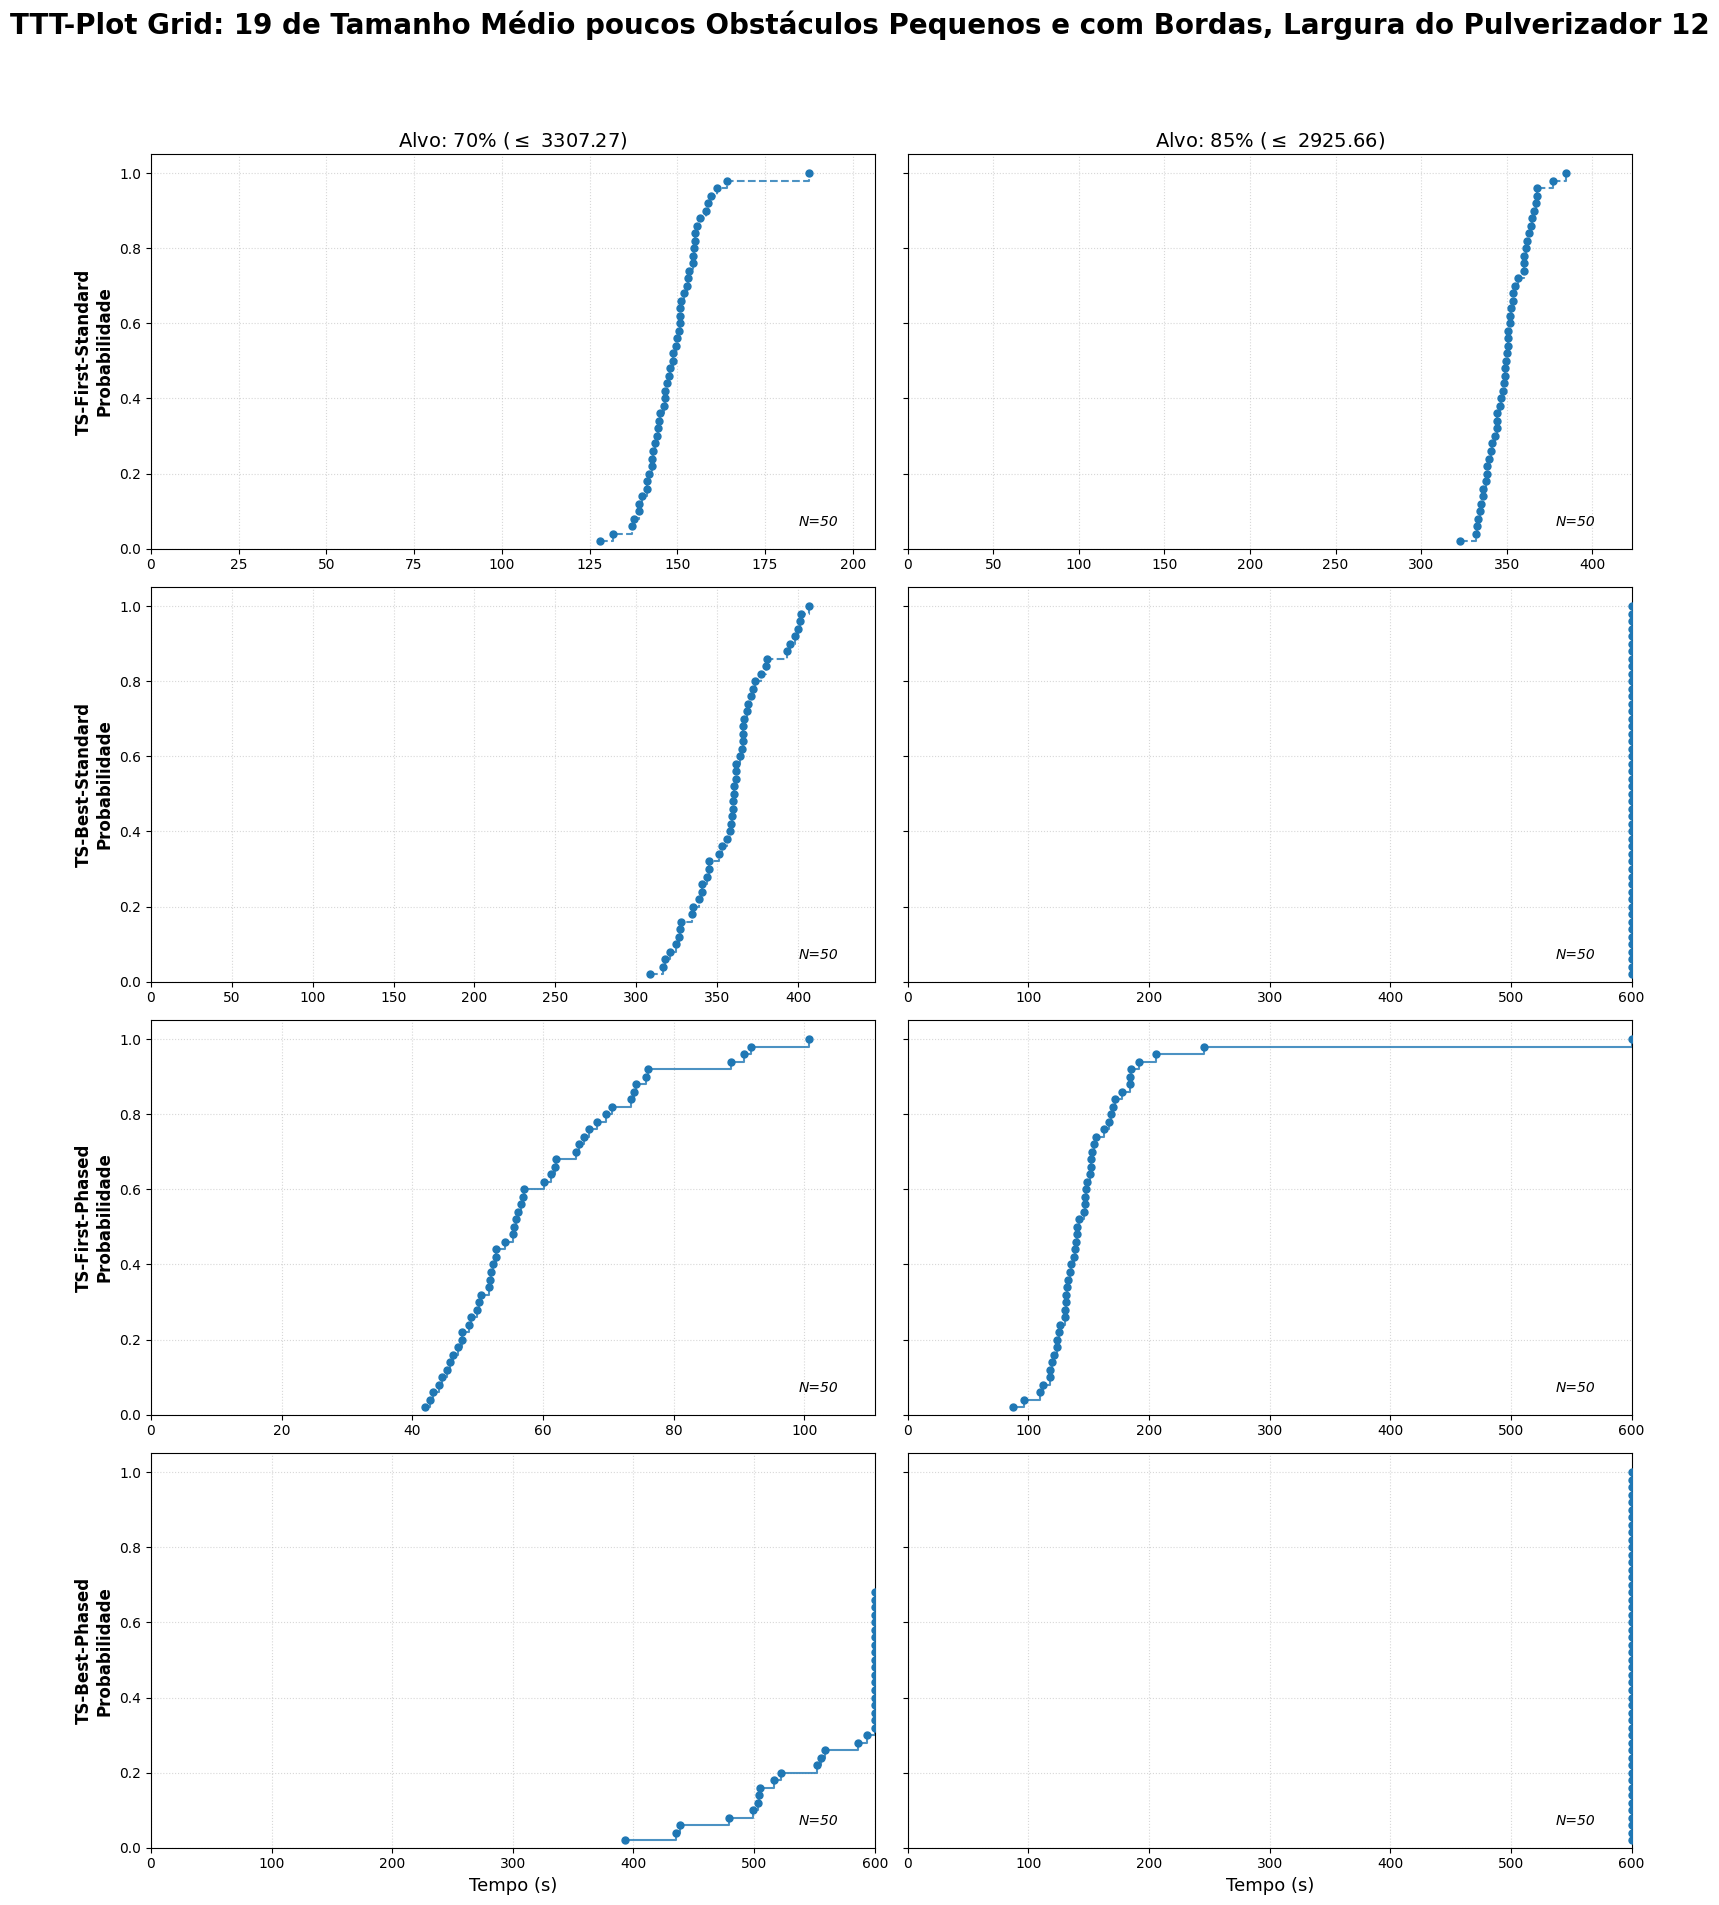

Gráfico TTT (Grid 4x2) salvo em: agricultural_csp/results_ttt\TTT_Plot_Grid_inst_14_medium_none_no_border_spray20.jpg


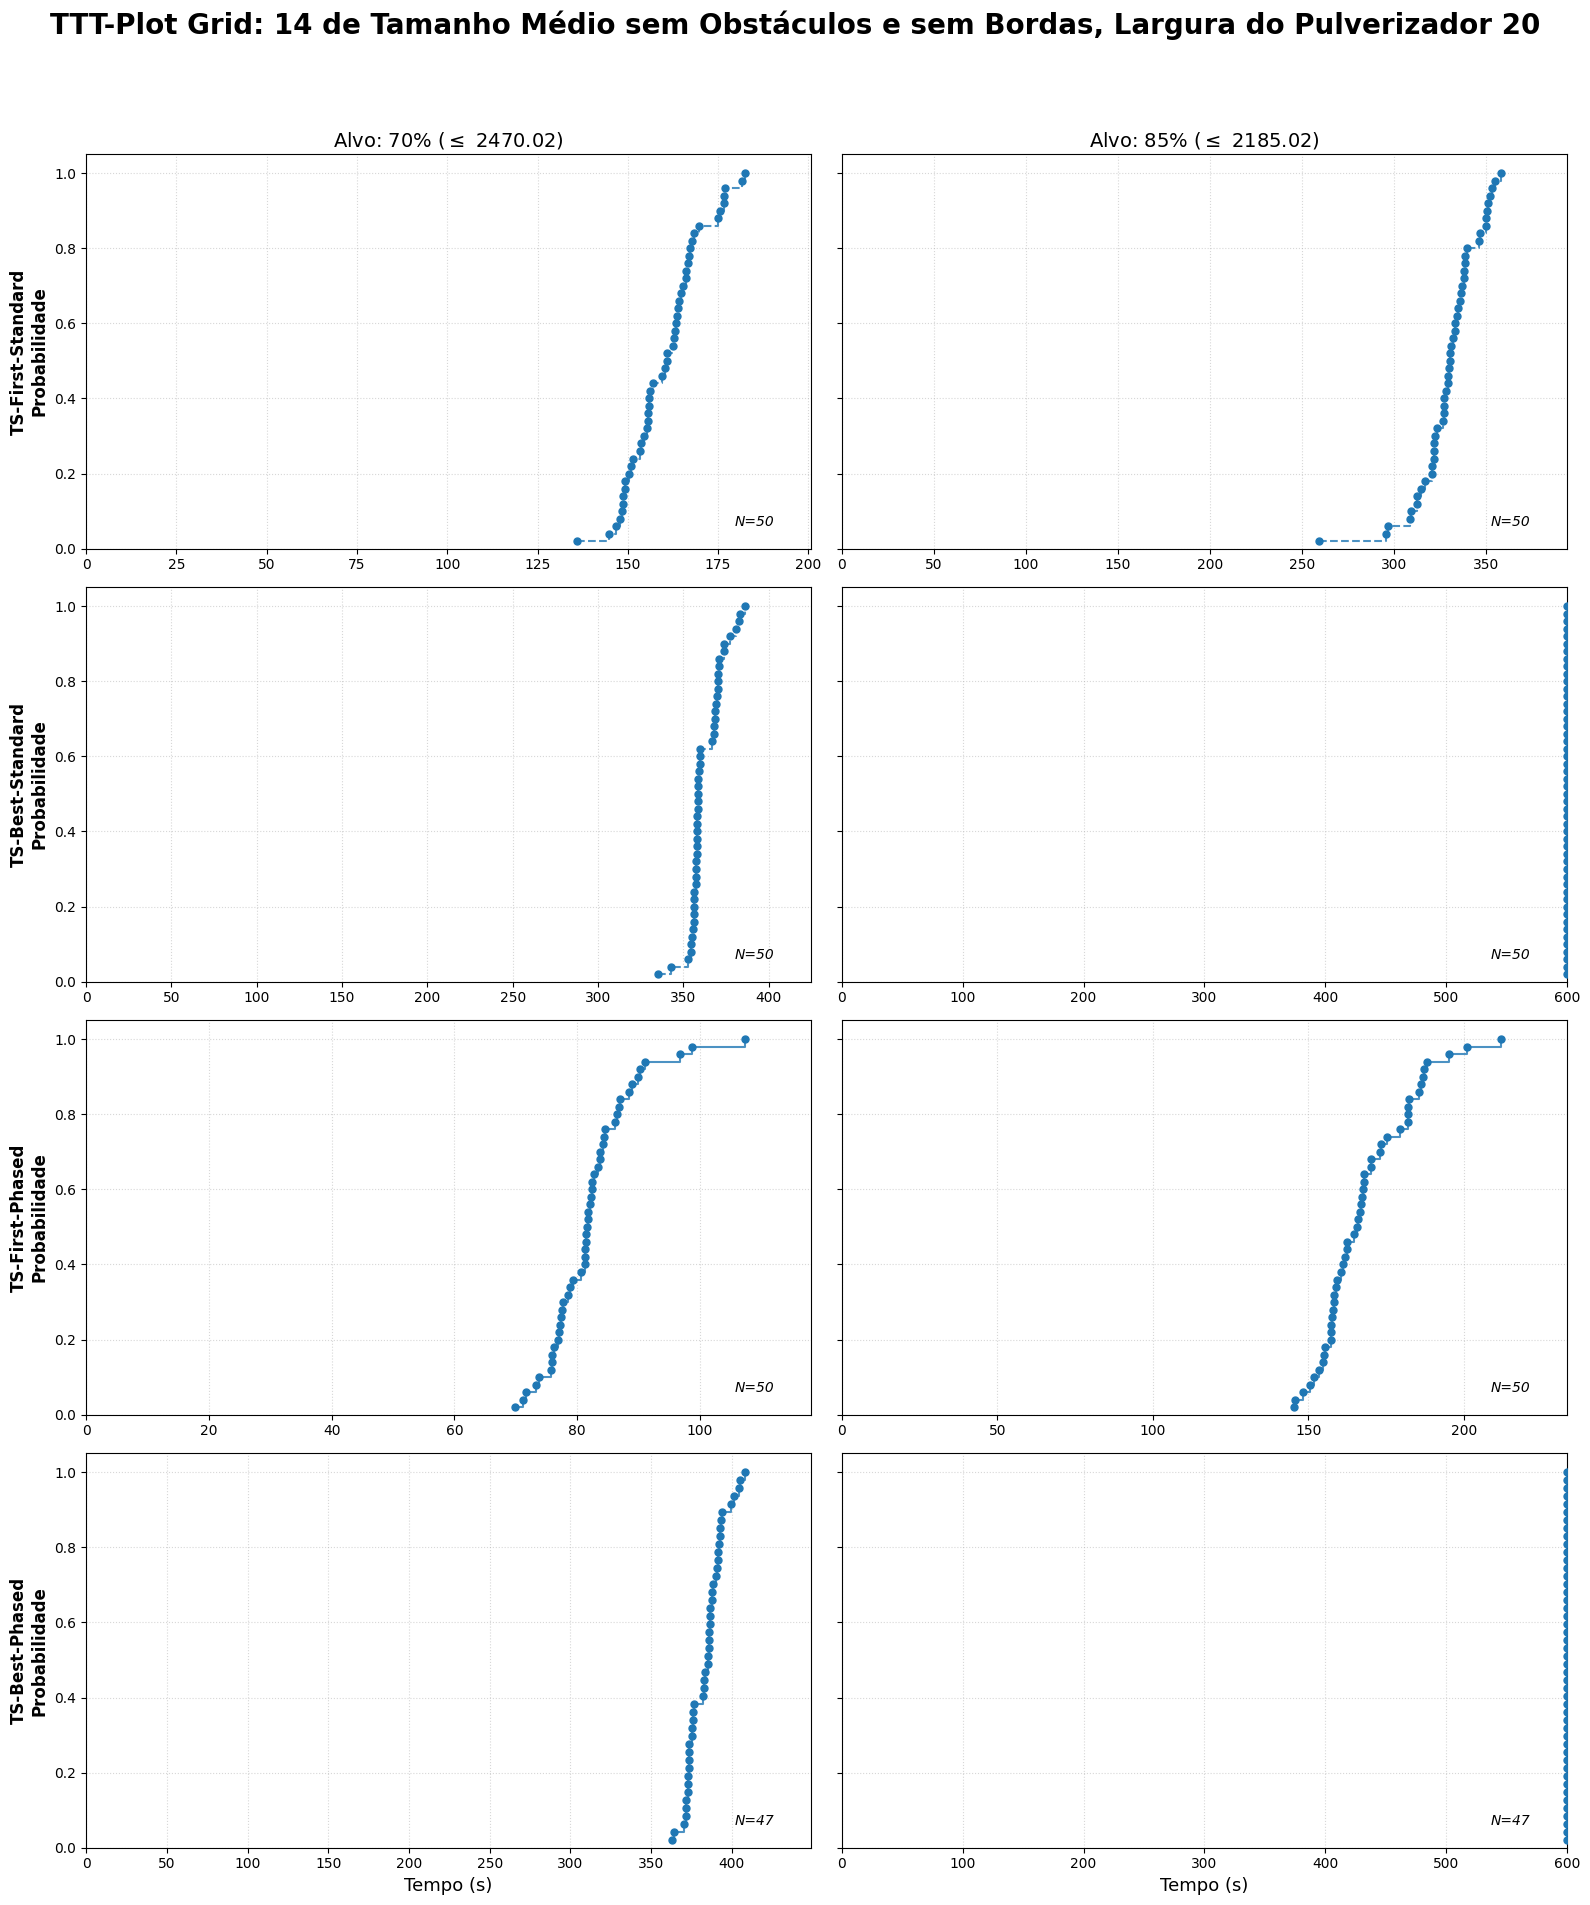

Gráfico TTT (Grid 4x2) salvo em: agricultural_csp/results_ttt\TTT_Plot_Grid_inst_26_large_none_no_border_spray20.jpg


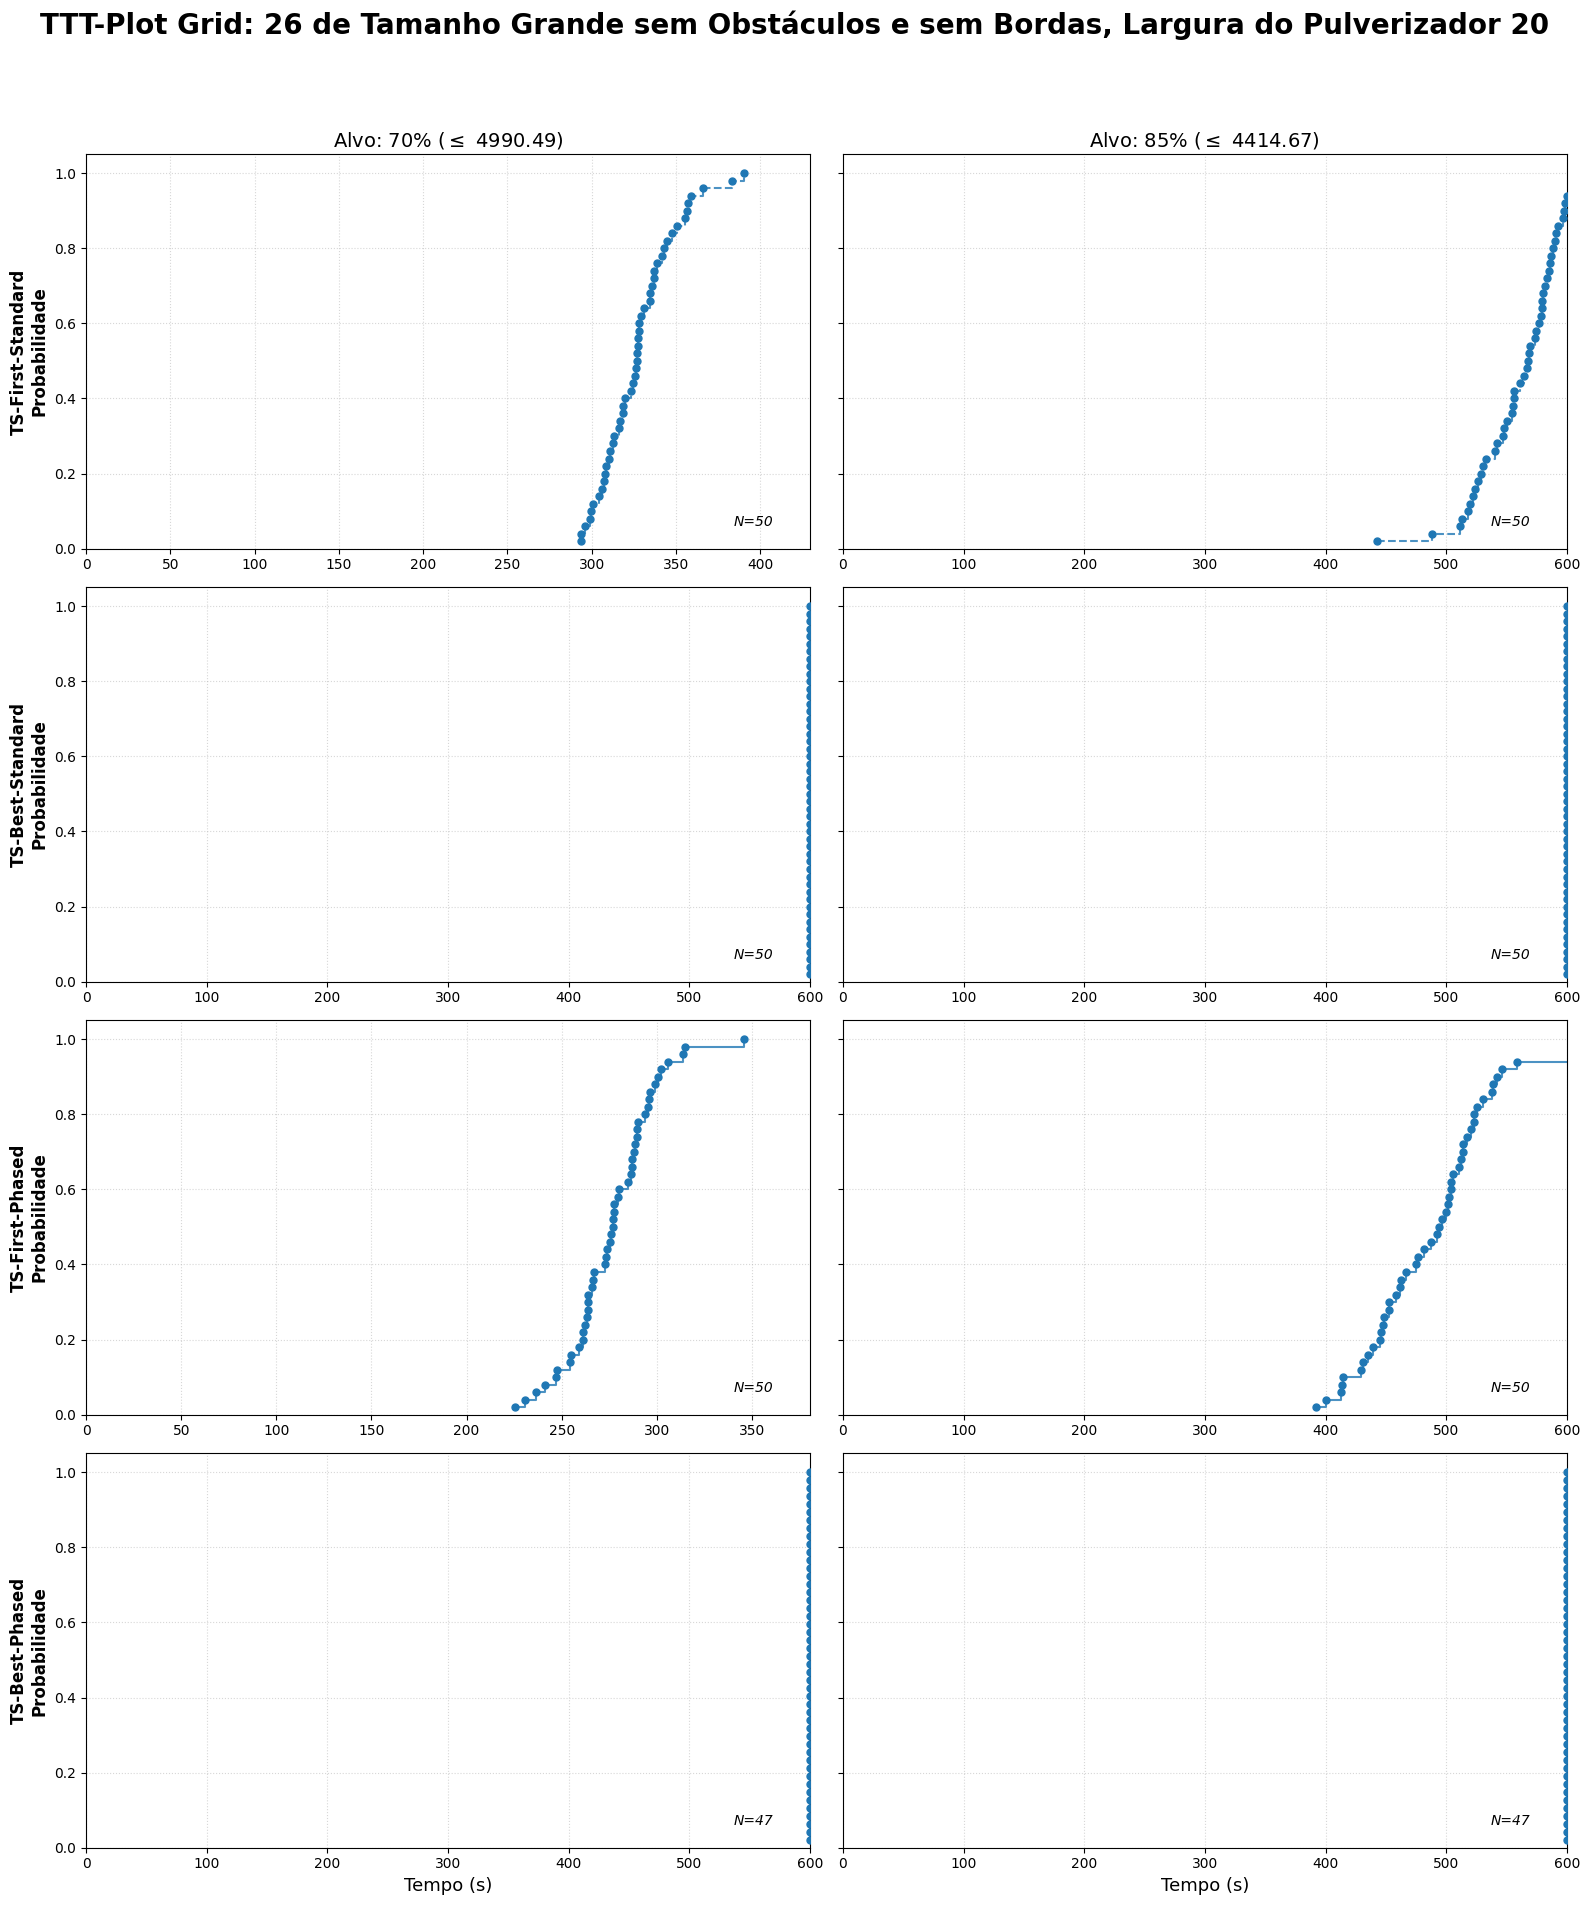

In [5]:
targets_map = {}
for inst, bks in bks_map.items():
    targets_map[inst] = {
        '70%': bks * 1.30, # Alvo Médio
        '85%': bks * 1.15  # Alvo Difícil
    }

print("\nValores Alvo (Targets) Definidos:")
print(json.dumps(targets_map, indent=2))

# Chama a nova função de plotagem em grid
plot_ttt_grid(all_data, instances, targets_map, INSTANCE_NAME_MAP)